# Linear regression

We'll solve the problem of linear regression in a few different ways:

- First we'll use `sklearn` to find the answer we're looking for
- Analytic solution for univariate problems
- The normal equation of linear algebra
- Singular value decomposition (this is what `sklearn` actually uses)
- Batch gradient descent
- Stochastic gradient descent
- Bayesian linear regression: maximum a posteriori

---

## Load some data

We'll use our 'rocks' data:

In [2]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_simple.csv')

df.head()

,Vp,Vs,rho,Lithology
0,3045.6,1595.7,2.109121,sandstone
1,3000.6,1517.1,2.090342,sandstone
2,3363.6,2041.5,2.131990,sandstone
3,3195.3,1606.2,2.184939,sandstone
4,4237.5,2448.6,2.472231,sandstone


Let's try to predict `Vs` from `Vp`. Later, you can try adding `Rho_n` as another feature to see how you can use these algorithms on multivariate data.

In [3]:
data = df[['Vp', 'Vs']].values

<h3>Random data</h3>

<p>If you prefer, you can make a dataset from a multivariate normal distribution, so we can control the statistics of the features and target.</p>

<b>To do this, run the following code:</b>

<pre>
import numpy as np

num_samples = 100

# The desired mean values of the sample.
mu = np.array([5.0, 5.0, 10.0])

# The desired covariance matrix.
r = np.array([
        [  2.00,  0.00, -2.00],
        [  0.00,  2.00,  2.00],
        [ -2.00,  2.00,  4.00]
    ])

# Generate the random samples.
data = np.random.multivariate_normal(mu, r, size=num_samples)
</pre>

## Make `X` and `y`

We can visualize the data:

<AxesSubplot:xlabel='x', ylabel='y'>

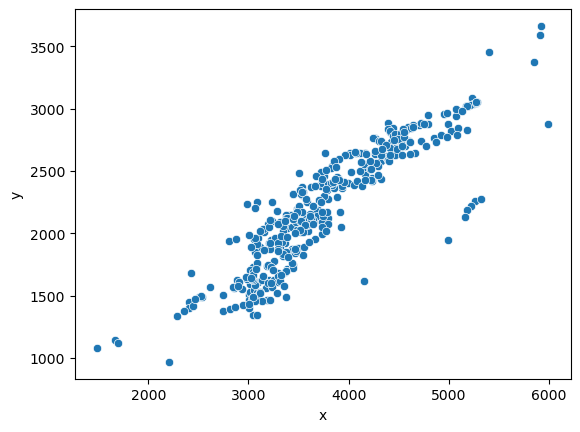

In [4]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data, columns=['x', 'y'])

sns.scatterplot(data=df, x='x', y='y')

In [5]:
# Univariate case
X = data[:, 0:1]
y = data[:, 1]

print(X.shape, y.shape)

(400, 1) (400,)


In the multivariate case, we should always standardize the data; in the univariate case, there's usually no need, but in my experience, gradient descent does not perform well on unscaled data, so let's standardize first.

In [6]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

## Solve with `sklearn`

We love and trust `sklearn` so let's start with that as a sort of baseline.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(X, y)

y_pred = model.predict(X)
print(f"MSE: {mean_squared_error(y, y_pred):.3f}\n")

w, b = model.coef_, model.intercept_

print(f"w = {w[0].item():.3f}\nb = {b:.3f}")

MSE: 46591.207

w = 431.562
b = 2188.855


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(X_, y_)

w, b = model.coef_, model.intercept_

w, b

(array([[0.89436988, 0.        ]]), array([-0.]))

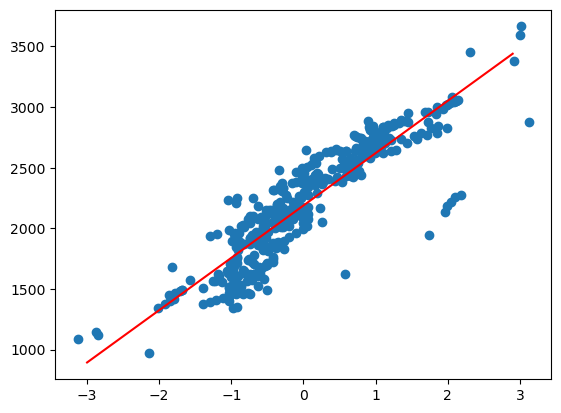

In [8]:
import numpy as np
import matplotlib.pyplot as plt

X_plt = np.arange(-3, 3, 0.1)
y_plt_sk = model.coef_[0]*X_plt + model.intercept_

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')
plt.show()

## Closed form solution: algebra

For the univariate case, it's possible to derive equations for the parameters based on the partial derivatives of the loss; the equations have a unique solution (equation 18.3 in _Artificial Intelligence: A Modern Approach_ (3rd ed.) by Stuart Russell and Peter Norvig, Pearson, 2016):

$$  $$

This is not to hard to compute in NumPy:

In [9]:
N = X.shape[0]
x = X[:, 0]

w = (N * (x*y).sum() - x.sum() * y.sum()) / (N * (x**2).sum() - x.sum()**2)

b = (y.sum() - w * x.sum()) / N

w, b

(431.5616664063004, 2188.8553005275007)

## Closed form solution: linear algebra

There's another analytic way to solve this equation that extends more easily to multivariate datasets (i.e. where `X` has more than one column). In principle, this is much faster and easier to do than gradient descent. In practice, it might be expensive or even intractable, e.g. on very large datasets, or with custom loss functions.

We need the so-called [**normal equation**](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations):

$$ \mathbf{y} = \mathbf{w}\mathbf{X} $$

We want the weights $\mathbf{w}$, so:

$$ \mathbf{w} = \mathbf{X}^{-1}\mathbf{y} $$

The catch is that $\mathbf{X}^{-1}$ may not be possible to compute, so we have to use [the pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of `X`, aka Moore&ndash;Penrose inverse. In our case:

$$ \mathbf{X}^{-1} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top $$

This approach is easier if we add a column of 1's to `X`, and concatenate the weights `w` with the bias `b`, so that we have a single data matrix and a single weight vector:

In [10]:
N = X.shape[0]
X_ = np.c_[X, np.ones((N, 1))]

X_[:5]

array([[-0.97030224,  1.        ],
       [-1.03277819,  1.        ],
       [-0.52880548,  1.        ],
       [-0.76246555,  1.        ],
       [ 0.68447761,  1.        ]])

That [`np.c_`](https://numpy.org/doc/stable/reference/generated/numpy.c_.html) implements a concatenation trick. You can also use `np.hstack`.

Now we can implement the 'naive' version of the normal equation:

In [11]:
np.set_printoptions(suppress=True)

In [12]:
import numpy.linalg as la

X_inv = la.inv(X_.T @ X_) @ X_.T  # The 'pseudoinverse' of X.

X_inv @ y

array([ 431.56166641, 2188.85530053])

We solved it! Pretty cool. But it won't always work...

## Singular value decomposition

The above method is computationally expensive (i.e. slow) and won't always work.

Internally, `sklearn` uses `scipy.linalg.lstsq()` and this, in turn, uses one of three algorithms in the Fortran library LAPACK (which NumPy depends on): `gelsd`, `gelsy` and `gelss`. Of these, `gelsd` and `gelss` use the singular value decomposition of our matrix `X_`.

In brief, we can solve:

$$ \mathbf{w} = \mathbf{V} \mathbf{\Sigma}^{+} \mathbf{U}^\top \, \mathbf{y} $$

[Read more about this.](https://towardsdatascience.com/why-gradient-descent-and-normal-equation-are-bad-for-linear-regression-928f8b32fa4f)

We could use `numpy.linalg.pinv()` to get the pseudoinverse directly...

In [13]:
la.pinv(X_) @ y

array([ 431.56166641, 2188.85530053])

...but where's the fun in that? Here's how to do it using the equation above, where the only really tricky part is forming $\Sigma^{+}$:

In [14]:
U, sigma, VT = la.svd(X_, full_matrices=False)

VT.T @ np.diag(1/sigma).T @ U.T @ y

array([ 431.56166641, 2188.85530053])

---

## Gradient descent

Let's solve the problem using gradient descent.

In order to optimize the weights using gradient descent, we need to know the **gradient** of the **cost function**. The cost $C$ over $N$ samples is given by:

$$ C = \frac{1}{N} \sum_{i=0}^{N} (\mathbf{y}_i - \hat{\mathbf{y}}_i)^2 $$

where the estimate $\hat{\mathbf{y}}$ is given by the matrix product of the weights $\theta$ and the 'augmented' data $\bar{\mathbf{X}}$ (the data plus an extra column of ones):

$$ \hat{\mathbf{y}} = \mathbf{w} \mathbf{X} + b = \theta \bar{\mathbf{X}} $$

Using this 'combined' weight matrix is easier than dealing with the weights and bias term separately. Note that $\theta$ is a vector, although it's displayed with an italic character here.

#### Chain rule

There are 2 functions here: the expression for $C$ and the one for $\hat{\mathbf{y}}$. The chain rule tells us how to differentiate a function of a function:

$$ \frac{\mathrm{d}}{\mathrm{d}x}\big[ f(g(x)) \big] = f^\prime(g(x))\ \times\ g^\prime(x) $$

Therefore the gradient $g$ is given by:

$$ g = \frac{\mathrm{d}C}{\mathrm{d}\theta} = \frac{\mathrm{d}C}{\mathrm{d}\hat{\mathbf{y}}}\ \times\ \frac{\mathrm{d}\hat{\mathbf{y}}}{\mathrm{d}\theta} $$

So our problem now looks like this:

$$ g = \frac{2}{N}\sum_{i=0}^{N} (\mathbf{y}_i - \hat{\mathbf{y}}_i)\ \times\ -\mathbf{X}_i $$

so if the error $\mathbf{e} = (\mathbf{y} - \hat{\mathbf{y}})$ then:

$$ g = -\frac{2}{N}\sum_{i=0}^{N} \mathbf{e}_i \mathbf{X}_i $$

In [15]:
alpha = 1e-3   # This must be tuned to the scale of the input.
epochs = 5_000

# Initialize.
cost_history = []
theta = np.zeros(X_.shape[1])

for i in range(epochs):
    # Make estimate with current weights.
    y_hat = theta @ X_.T
    
    # Compute error and cost.
    err = y - y_hat
    cost = np.sum(err**2) / N
    cost_history.append(cost)
    if i % (epochs // 10) == 0:
        print(f"{i:>8d} {cost:.3f}")
        
    # Compute gradients (one for each feature).
    grad = (-2/N) * np.sum(err[:, None] * X_, axis=0)
    
    # Adjust weights.
    theta -= alpha * grad

print(f"{'end':>8s} {cost:.3f}")

       0 5023924.206
     500 718852.312
    1000 137389.832
    1500 58854.880
    2000 48247.594
    2500 46814.926
    3000 46621.424
    3500 46595.288
    4000 46591.758
    4500 46591.282
     end 46591.217


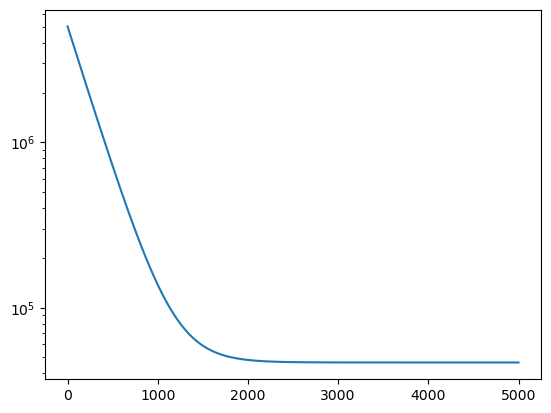

In [16]:
plt.plot(cost_history)
plt.yscale('log')

Let's make sure it's similar to what we got before, which was

In [17]:
# With sklearn...
w, b

(431.5616664063004, 2188.8553005275007)

In [18]:
# With gradient descent...
theta

array([ 431.54226875, 2188.75691675])

## Stochastic gradient descent

Here, we're computing the cost over the entire dataset. In practice, this might not be possible, especially on high-dimensional datasets. We can reduce the computational burden by computing the cost over smaller 'batches'. This is known as 'stochastic gradient descent'. 

We'll also shuffle the data before each epoch (one epoch is one pass through the entire dataset). This helps to avoid getting stuck in a local minimum, because every time we take a step on the cost surface, we're on a slightly different version of the surface.

In [19]:
alpha = 1e-3
epochs = 500
batch_size = 50

splits = np.arange(batch_size, N, batch_size)
idx = np.arange(N)

# Initialize.
cost_history = []
theta = np.random.random(X_.shape[1])

for i in range(epochs):
    
    # Shuffle the data.
    np.random.shuffle(idx)
    X_shuffle = X_[idx]
    y_shuffle = y[idx]
    X_batches = np.split(X_shuffle, splits)
    y_batches = np.split(y_shuffle, splits)

    for j, (X_batch, y_batch) in enumerate(zip(X_batches, y_batches)):

        # Make estimate with current weights.
        y_hat = theta @ X_batch.T

        # Compute error and (once per epoch) cost.
        err = y_batch - y_hat
        
        if j == 0:
            cost = np.sum(err**2) / batch_size
            cost_history.append(cost)

        # Compute gradients (one for each feature).
        grad = (-2/batch_size) * np.sum(err[:, None] * X_batch, axis=0)

        # Adjust weights.
        theta -= alpha * grad

    if i % (epochs // 10) == 0:
        print(f"{i:>8d} {cost:.3f}")

print(f"{'end':>8s} {cost:.3f}")

       0 5168871.871
      50 929875.135
     100 248070.734
     150 86929.375
     200 59142.855
     250 48613.600
     300 33829.450
     350 56428.320
     400 27150.286
     450 54323.017
     end 89438.646


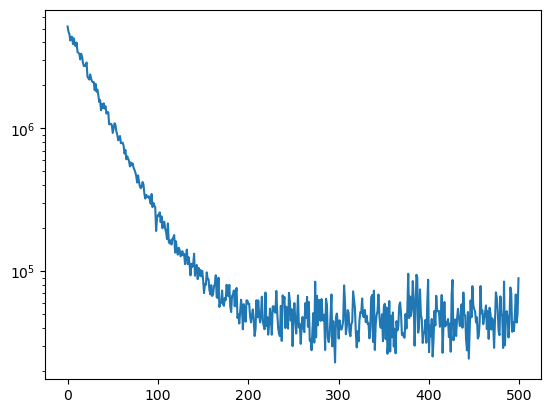

In [20]:
plt.plot(cost_history)
plt.yscale('log')

Notice that this converges much faster than using the entire dataset: only 500 epochs, compared to 5000.

In [21]:
theta

array([ 431.41595476, 2188.12623752])

This compares well with what we got from `sklearn`:

In [22]:
w, b

(431.5616664063004, 2188.8553005275007)

And let's check the new parameters against the previous solution:

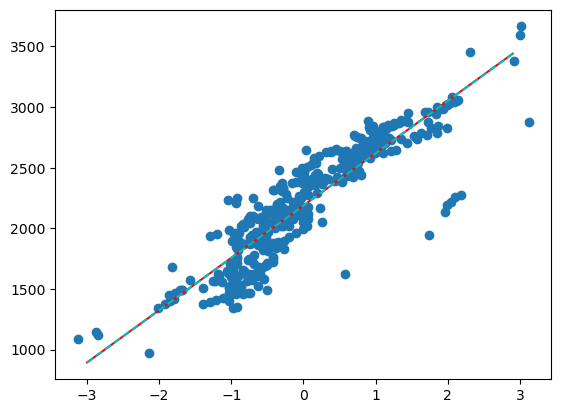

In [23]:
# Two parameters:
w_sgd, b_sgd = theta

y_plt = w_sgd*X_plt + b_sgd

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')  # regression line
plt.plot(X_plt, y_plt, '--', color='c')  # regression line
plt.show()

It matches!

## Compare with `sklearn`'s own SGD regressor

Let's try with [`sklearn.linear_model.SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html), which implements a generic SGD regressor that can solve linear regression (with or without regularization).

In [24]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(alpha=0).fit(X, y)  # Turn off regularization.

y_pred = model.predict(X)
print(f"MSE: {mean_squared_error(y, y_pred):.3f}\n")

(w,), (b, ) = model.coef_, model.intercept_
print(f"w0 = {w:.3f}\nb = {b:.3f}")

MSE: 46591.404

w0 = 431.196
b = 2188.605


It matches too!

## Bayesian linear regression

In [154]:
N, M = X_.shape
alpha = 1  # Init.
beta = 10   # Init.
mean = np.zeros(M)
lamda = 1e-6  # Regularization.

weights = []

for _ in range(200):
    cov_inv_0 = np.identity(M) / alpha
    for xi, yi in zip(X_, y):

        # Update the (inverse) covariance, Bishop's equation 3.51.
        cov_inv_N = cov_inv_0 + beta * np.outer(xi, xi)

        # Update the mean, Bishop's equation 3.50.
        cov_N = la.inv(cov_inv_N)
        mean = cov_N @ (cov_inv_0 @ mean + beta * xi * yi)
        cov_inv_0 = cov_inv_N

        weights.append((mean, cov))

    # Update alpha and beta
    Ew = 0.5 * mean @ mean
    Ed = lamda * Ew
    alpha = M / (2 * Ew * mean)
    beta = N / (2 * Ed * mean)

weights[-1]

(array([ 431.45380445, 2188.30822375]),
 array([[0.68182876, 0.32994525],
        [0.32995369, 0.65839789]]))

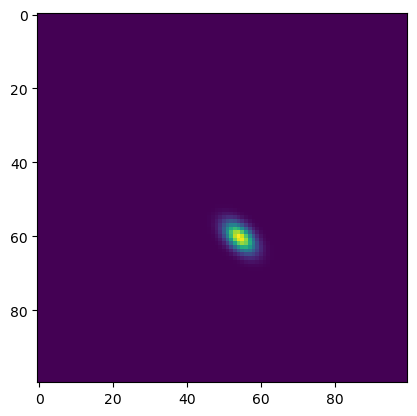

In [181]:
from scipy import stats

m, s = weights[400]

cov = np.linalg.inv(cov_inv)
dist = stats.multivariate_normal(mean=m, cov=s)

w = np.linspace(415, 445, 100)
b = np.linspace(2170, 2200, 100)
W = np.dstack(np.meshgrid(w, b))
pdf = dist.pdf(W)

import matplotlib.pyplot as plt
plt.imshow(pdf)

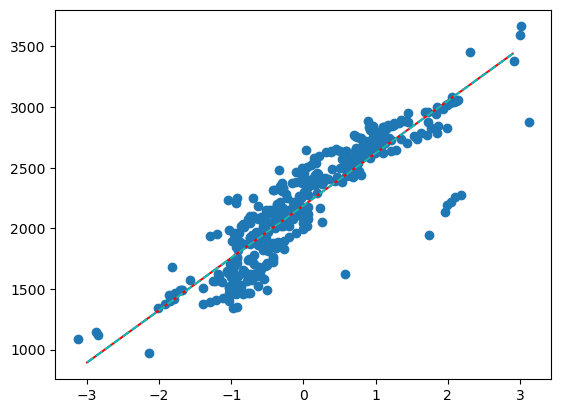

In [182]:
w, b = m
y_plt = w*X_plt + b

plt.scatter(X[:, 0], y) 
plt.plot(X_plt, y_plt_sk, color='r')  # regression line
plt.plot(X_plt, y_plt, '--', color='c')  # regression line
plt.show()

They match! Nice.

----

&copy; 2022 Matt Hall / [https://github.com/kwinkunks](https://github.com/kwinkunks) / MIT licence